# Homework 5 - Andrew Schwartz - PHYS 403, SPR 2024

## 1. Credible and Confidence intervals 

We will again consider a dataset (download from Blackboard) with a linear hypothesis.

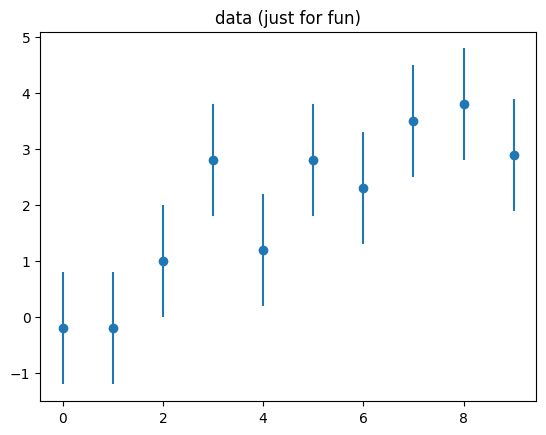

In [2]:
import numpy as np
from matplotlib import pyplot as plt

π = np.pi

x, y, σy = np.fromstring("""0 -0.2 1.00
1 -0.2 1.00
2 1.0 1.00
3 2.8 1.00
4 1.2 1.00
5 2.8 1.00
6 2.3 1.00
7 3.5 1.00
8 3.8 1.00
9 2.9 1.00""", dtype=float, sep=' ').reshape((10, 3)).T

plt.errorbar(x, y, σy, fmt='o')
plt.title('data (just for fun)')
plt.show()

σy = σy[0]

### a

Assume a single parameter $y = f(x) = m \cdot x$, where $m$ is the unknown slope. Plot the Bayesian posterior PDF assuming a prior that enforces $m > 0$, and compare the result to a prior that does not. (Use a flat prior in $m$, with $0 < m < 1$ in the first case and $−1 < m < 1$ in the second case.) Does your *a priori* knowledge of $m > 0$ change the result?

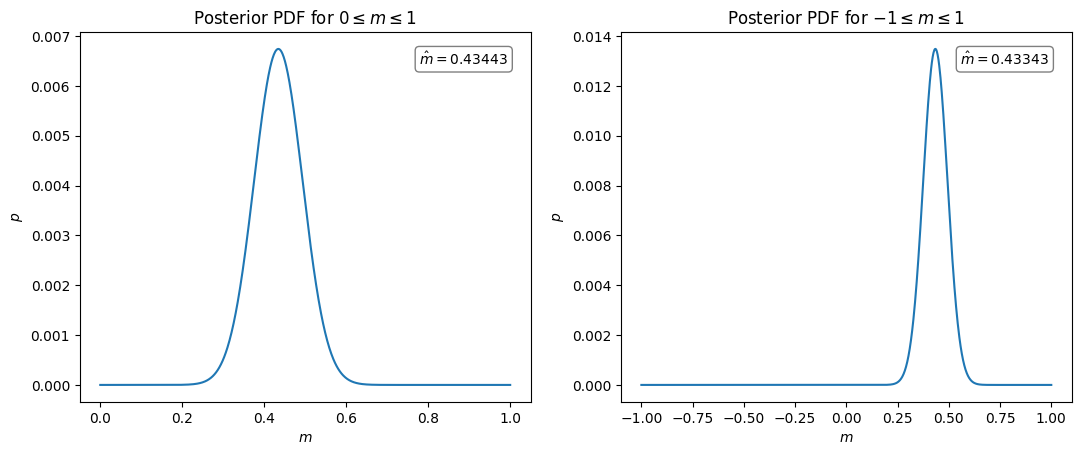

In [3]:
def posterior(prior, m):
    n = len(x)
    return prior * (1 / (2 * π * σy ** 2)) ** (n / 2) * np.exp(-1 / (2 * σy ** 2) * np.sum((m * x - y) ** 2))


def calc_pdf(start):
    m = np.linspace(start, 1, 1000)
    pdf = [posterior(1 / (1 - st), m) for m in m]
    pdf /= np.sum(pdf)
    return m, pdf


fig, ax = plt.subplots(1, 2, figsize=(6.4 * 2, 4.8))

for st in (0, -1):
    m, pdf = calc_pdf(st)
    idx = np.argmax(pdf)
    ax[-st].plot(m, pdf)
    ax[-st].set(
        xlabel='$m$',
        ylabel='$p$',
        title=f'Posterior PDF for ${st}\leq m\leq1$'
    )
    ax[-st].text(0.95, 0.95, f'$\hat m={m[idx]:.5}$', transform=ax[-st].transAxes,
                 fontsize=10, verticalalignment='top', horizontalalignment='right',
                 bbox=dict(facecolor='white', alpha=0.5, boxstyle='round'))

plt.show()

Not really :(

### b

Determine the 68% and 90% credible intervals in the case of the non-negative prior.

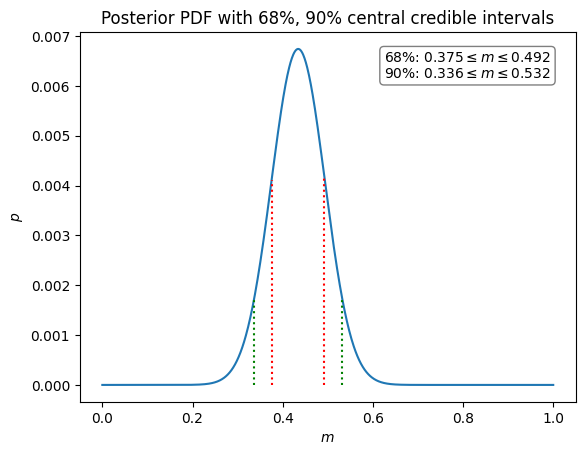

In [4]:
m, pdf = calc_pdf(0)
cdf = np.add.accumulate(pdf)
idx = np.argmax(pdf)

idxs = [np.argmin(np.abs(cdf - lim)) for lim in [0.05, 0.16, 0.84, 0.95]]

fix, ax = plt.subplots()
ax.plot(m, pdf)
ax.vlines(m[idxs], 0, pdf[idxs], color=["green", "red", "red", "green"], ls=':')
ax.set(
    xlabel='$m$',
    ylabel='$p$',
    title=f'Posterior PDF with 68%, 90% central credible intervals'
)
ax.text(0.95, 0.95, f'68%: ${m[idxs[1]]:.3}\leq m\leq{m[idxs[2]]:.3}$\n90%: ${m[idxs[0]]:.3}\leq m\leq{m[idxs[3]]:.3}$',
        transform=ax.transAxes,
        fontsize=10, verticalalignment='top', horizontalalignment='right',
        bbox=dict(facecolor='white', alpha=0.5, boxstyle='round'))
plt.show()

### c

Compute instead the 68% and 90% upper limits from the posterior PDFs. Comment on the upper limits, compared to the upper bounds of the credible intervals.

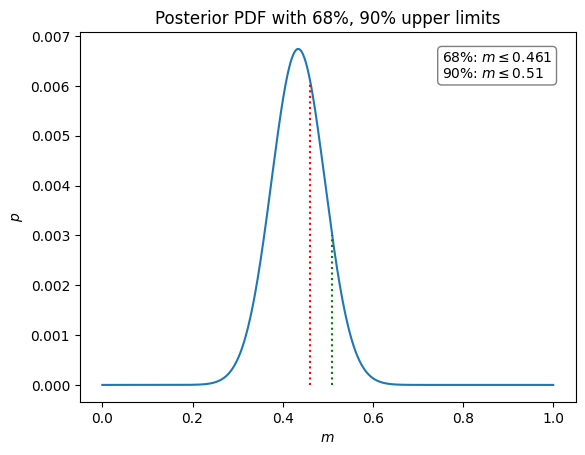

In [5]:
idxs = [np.argmin(np.abs(cdf - lim)) for lim in [0.68, 0.9]]

fig, ax = plt.subplots()
ax.plot(m, pdf)
ax.vlines(m[idxs], 0, pdf[idxs], colors=["red", "green"], ls=':')
ax.set(
    xlabel='$m$',
    ylabel='$p$',
    title=f'Posterior PDF with 68%, 90% upper limits'
)
ax.text(0.73, 0.95, f'68%: $m\leq{m[idxs[0]]:.3}$\n90%: $m\leq{m[idxs[1]]:.3}$', transform=ax.transAxes,
        fontsize=10, verticalalignment='top', horizontalalignment='left',
        bbox=dict(facecolor='white', alpha=0.5, boxstyle='round'))
plt.show()

### d

Now perform a frequentist analysis. First, plot the $\chi^2$ as a function of $m$. Find the minimum using a built-in minimizer, such as $\texttt{scipy.optimize.minimize}$. Determine the $\Delta\chi^2$ between the best-fit and the case of $m = 0$.

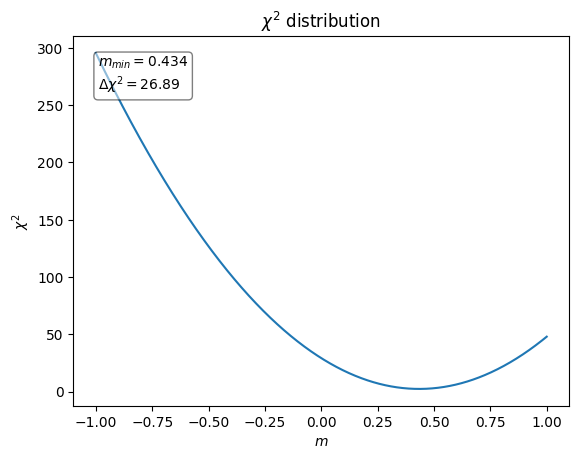

In [7]:
from scipy.optimize import minimize

m, pdf = calc_pdf(-1)
cdf = np.add.accumulate(pdf)
idx = np.argmax(pdf)

chi2_fn = lambda m, x=x, y=y: 1 / (2 * σy) * np.sum((y - m * x) ** 2)
chi2 = np.array([chi2_fn(m) for m in m])

min = minimize(chi2_fn, 0, method='Nelder-Mead').x[0]

Δchi2 = chi2_fn(0) - chi2_fn(min)

fix, ax = plt.subplots()
ax.plot(m, chi2)
ax.set(
    xlabel='$m$',
    ylabel='$\chi^2$',
    title=f'$\chi^2$ distribution'
)
ax.text(0.05, 0.95, f'$m_{{min}}={min:.3}$\n$\Delta\chi^2={Δchi2:.4}$', transform=ax.transAxes,
        fontsize=10, verticalalignment='top', horizontalalignment='left',
        bbox=dict(facecolor='white', alpha=0.5, boxstyle='round'))
plt.show()

### e

Determine the 68% and 90% upper bounds using a Feldman-Cousins technique. Simulate pseudo-experiments assuming $m = 0$, with each pseudo-experiment consisting of 10 data points with a Gaussian uncertainty with $σ_y = 1.0$. In each pseudo-experiment, determine the best-fit slope, and the $\Delta\chi^2$ between the best-fit and the case of $m = 0$. Find the critical $\Delta\chi^2$ corresponding to 68% and 90% of the pseudo-experiments. With what confidence can $m = 0$ be excluded?


  0%|          | 0/50000 [00:00<?, ?it/s]

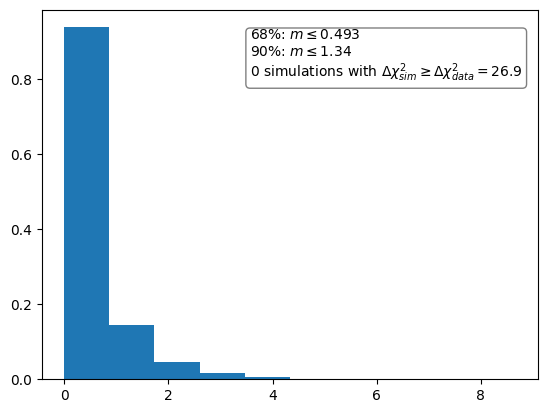

In [21]:
from tqdm.notebook import tqdm

rng = np.random.default_rng()

n_exp = 50000

x = np.arange(0, 10)
ys = rng.standard_normal((n_exp, 10))

log_likelihood = lambda m, y: chi2_fn(m, x, y)


def experiment_stuff(y):
    ll = lambda m: log_likelihood(m, y)
    m = minimize(ll, 0, method='BFGS').x[0]
    delta = ll(0) - ll(m)
    return m, delta


slopes, deltas = np.array([experiment_stuff(y) for y in tqdm(ys)]).T

idxs = np.percentile(deltas, [68, 90])
n_gt_Δχ = np.count_nonzero(deltas > Δchi2)

fig, ax = plt.subplots()
ax.hist(deltas, density=True)
ax.text(0.42, 0.95, f'68%: $m\leq{idxs[0]:.3}$\n90%: $m\leq{idxs[1]:.3}$\n{n_gt_Δχ} simulations with $\Delta\chi^2_{{sim}}\geq\Delta\chi^2_{{data}}={Δchi2:.3}$', transform=ax.transAxes,
        fontsize=10, verticalalignment='top', horizontalalignment='left',
        bbox=dict(facecolor='white', alpha=0.5, boxstyle='round'))
plt.show()

Since there are no simulations with $\Delta\chi^2{sim}\geq\Delta\chi^2_{data}$, we have $alpha=1-\frac{0}{50000}=1$, a 100% confidence we can exclude $m=0$.